In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt

import sys; sys.path.insert(0, "../")
import sys; sys.path.insert(0, "../inverse_parametric_burgers/")

import numpy as np
from utils import *
from models import TanhProb
from parametric_discovery_pinnV2 import ParametricSolver

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew

from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR, DLrSR
from parametric_pde_diff import TrainSGTRidge, create_groups
from pytorch_robust_pca import R_pca

from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time

from pysr import pysr, best

fontsize = 20

Populating the interactive namespace from numpy and matplotlib
Running Python 3.9.7
You can use npar for np.array


In [2]:
noise_intensity = 0.01; noisy_xt = False

In [3]:
data = pickle_load("../parametric_pde_data/parametric_advection_diffusion.pkl")

x = data['x']; spatial_dims = x.shape[0]
t = data['t']; time_dims = t.shape[0]

Exact = data['u']
# Exact = data['u'].T
X, T = np.meshgrid(x, t)

if noise_intensity > 0.0:
    print("Noisy Exact")
    Exact = perturb(Exact, intensity=noise_intensity, noise_type="normal")
else: print("Clean Exact")

X_star = np.hstack((to_column_vector(X), to_column_vector(T)))
u_star = to_column_vector(Exact.T)

# domain bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

# Sampling training data points
N = 20000
training_idxs = sampling_from_rows(X_star, N, True)
X_train = X_star[training_idxs, :]
u_train = u_star[training_idxs, :]

if noise_intensity > 0.0 and noisy_xt:
    print("Noisy X_train")
    X_train = perturb(X_train, intensity=noise_intensity, noise_type="normal")
else: print("Clean X_train")

# to_tensor
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)
X_train = to_tensor(X_train, True)
u_train = to_tensor(u_train, False)
lb = to_tensor(lb, False)
ub = to_tensor(ub, False)

L = 5
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L)
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(spatial_dims)

Loaded from ../parametric_pde_data/parametric_advection_diffusion.pkl
Noisy Exact
Clean X_train


In [4]:
class AttentionSelectorNetwork(nn.Module):
    def __init__(self, layers, prob_activation=torch.sigmoid, bn=None, reg_intensity=1e-3):
        super(AttentionSelectorNetwork, self).__init__()
        # Nonlinear model, Training with PDE reg.
        assert len(layers) > 1
        self.linear1 = nn.Linear(layers[0], layers[0])
        self.prob_activation = prob_activation
        self.nonlinear_model = TorchMLP(dimensions=layers, activation_function=nn.Tanh, bn=bn, dropout=nn.Dropout(p=0.1))
        self.latest_weighted_features = None
        self.th = (1/layers[0])-(1e-10)
        self.reg_intensity = reg_intensity
        self.w = torch.tensor([1.0, 1.0, 1.0, 2.0, 3.0, 4.0])
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, inn, bi=False):
        if bi: att = binarize(self.weighted_features(inn), self.th)
        else: att = F.threshold(self.weighted_features(inn), self.th, 0.0)
        return self.nonlinear_model(inn*att)
    
    def weighted_features(self, inn):
        self.latest_weighted_features = self.prob_activation(self.linear1(inn)).mean(axis=0)
        return self.latest_weighted_features
    
    def loss(self, X_input, y_input):
        ut_approx = self.forward(X_input)
        mse_loss = F.mse_loss(ut_approx, y_input, reduction='mean')
        reg_term = F.relu(self.latest_weighted_features-self.th)
        
        l1 = mse_loss
        l2 = torch.norm(reg_term, p=0)+torch.dot(self.w, reg_term)
        
        return l1+self.reg_intensity*(l2)

class SemiSupModel(nn.Module):
    def __init__(self, network, selector, normalize_derivative_features=False, mini=None, maxi=None):
        super(SemiSupModel, self).__init__()
        self.network = network
        self.selector = selector
        self.normalize_derivative_features = normalize_derivative_features
        self.mini = mini
        self.maxi = maxi
        
    def forward(self, X_u_train):
        X_selector, y_selector = self.network.gradients_dict(*dimension_slicing(X_u_train))
        est = X_selector[:, 0:1]
        if self.normalize_derivative_features:
            X_selector = (X_selector-self.mini)/(self.maxi-self.mini)
        unsup_loss = self.selector.loss(X_selector, y_selector)
        return est, unsup_loss

In [5]:
### Version with normalized derivatives ###
pretrained_state_dict = torch.load("./new_weights/pretrained_20000samples.pth")
network_state_dict = None # always set to None
use_pretrained_weights = True
lets_pretrain = False

semisup_model = SemiSupModel(network=ParametricSolver(scale=False, lb=lb, ub=ub, input_feature='x', highest_order=4),
                            # Be careful of choosing the prob_activation to compute the attentional weights!
                            selector=AttentionSelectorNetwork([6, 50, 50, 1], prob_activation=TanhProb(), bn=nn.LayerNorm),
#                             selector=AttentionSelectorNetwork([5, 50, 50, 1], bn=nn.LayerNorm),
                            normalize_derivative_features=False,
                            mini=None,
                            maxi=None)

if use_pretrained_weights:
    print("Use pretrained weights")
    semisup_model.load_state_dict(pretrained_state_dict, strict=False)
    network_state_dict = semisup_model.network.state_dict()
    semisup_model.eval()
    referenced_derivatives, _ = semisup_model.network.gradients_dict(*dimension_slicing(X_star))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

Using old implementation of TorchMLP. See models.py for more new model-related source code.
Use pretrained weights


In [6]:
if lets_pretrain:
    print("Pretraining...")
    pretraining_optimizer = LBFGSNew(semisup_model.network.parameters(), 
                                     lr=1e-1, max_iter=300, 
                                     max_eval=int(300*1.25), history_size=150, 
                                     line_search_fn=True, batch_mode=False)

    semisup_model.train()
    for i in range(200):
        def pretraining_closure():
            global N, X_train, u_train
            if torch.is_grad_enabled(): pretraining_optimizer.zero_grad()
            # Only focusing on first [:N, :] elements
            mse_loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_train))[:N, :], u_train[:N, :])
            if mse_loss.requires_grad: mse_loss.backward(retain_graph=False)
            return mse_loss

        pretraining_optimizer.step(pretraining_closure)

        l = pretraining_closure()
        if (i % 10) == 0:
            curr_loss = l.item()
            print("Epoch {}: ".format(i), curr_loss)
            
            # Sneak on the test performance...
            semisup_model.network.eval()
            test_performance = F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()
            string_test_performance = scientific2string(test_performance)
            print('Test MSE:', string_test_performance)
    
    print("Computing derivatives features")
    semisup_model.eval()
    referenced_derivatives, _ = semisup_model.network.gradients_dict(*dimension_slicing(X_star))
    semisup_model.mini = torch.min(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)
    semisup_model.maxi = torch.max(referenced_derivatives, axis=0)[0].detach().requires_grad_(False)

In [7]:
F.mse_loss(semisup_model.network(*dimension_slicing(X_star)).detach(), u_star).item()

6.600582128157839e-05

In [8]:
def pcgrad_closure(return_list=False):
    global N, X_train, u_train
    predictions, unsup_loss = semisup_model(X_train)
    losses = [F.mse_loss(predictions[:N, :], u_train[:N, :]), unsup_loss]
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in semisup_model.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(semisup_model.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return losses[0]+losses[1]
    else: return losses

In [9]:
# Joint training | Do lambda comparison here
optimizer = MADGRAD([{'params':semisup_model.network.parameters()}, {'params':semisup_model.selector.parameters()}], lr=1e-6)
optimizer.param_groups[0]['lr'] = 1e-7
optimizer.param_groups[1]['lr'] = 1e-1

In [10]:
# Use ~idx to sample
for i in range(250):
    semisup_model.train()
    optimizer.step(pcgrad_closure)
    if i%25==0:
        loss = pcgrad_closure(return_list=True); print(loss)
        fi = semisup_model.selector.latest_weighted_features
        print(fi); print(torch.argsort(fi))

[tensor(0.0015, grad_fn=<MseLossBackward0>), tensor(1.7129, grad_fn=<AddBackward0>)]
tensor([0.5542, 0.4202, 0.5295, 0.4526, 0.5425, 0.4575],
       grad_fn=<MeanBackward1>)
tensor([1, 3, 5, 2, 4, 0])
[tensor(0.0364, grad_fn=<MseLossBackward0>), tensor(0.1577, grad_fn=<AddBackward0>)]
tensor([0.7046, 0.3348, 0.7673, 0.5253, 0.5098, 0.1910],
       grad_fn=<MeanBackward1>)
tensor([5, 1, 4, 3, 0, 2])
[tensor(0.0363, grad_fn=<MseLossBackward0>), tensor(0.0564, grad_fn=<AddBackward0>)]
tensor([0.8482, 0.3187, 0.8672, 0.4884, 0.4475, 0.1225],
       grad_fn=<MeanBackward1>)
tensor([5, 1, 4, 3, 0, 2])
[tensor(0.0246, grad_fn=<MseLossBackward0>), tensor(0.0499, grad_fn=<AddBackward0>)]
tensor([0.8710, 0.2693, 0.8525, 0.4708, 0.3721, 0.1297],
       grad_fn=<MeanBackward1>)
tensor([5, 1, 4, 3, 2, 0])
[tensor(0.0172, grad_fn=<MseLossBackward0>), tensor(0.0395, grad_fn=<AddBackward0>)]
tensor([0.9358, 0.2186, 0.7557, 0.4203, 0.3220, 0.1320],
       grad_fn=<MeanBackward1>)
tensor([5, 1, 4, 3, 2,

In [11]:
semisup_model.train()
for i in range(100):
    optimizer.step(pcgrad_closure)
    if i%25==0:
        loss = pcgrad_closure(return_list=True); print(loss)
        fi = semisup_model.selector.latest_weighted_features
        print(fi); print(torch.argsort(fi))

[tensor(0.0038, grad_fn=<MseLossBackward0>), tensor(0.0325, grad_fn=<AddBackward0>)]
tensor([0.8685, 0.1543, 0.6816, 0.3211, 0.2566, 0.1380],
       grad_fn=<MeanBackward1>)
tensor([5, 1, 4, 3, 2, 0])
[tensor(0.0027, grad_fn=<MseLossBackward0>), tensor(0.0302, grad_fn=<AddBackward0>)]
tensor([0.8773, 0.1553, 0.6745, 0.3051, 0.2076, 0.1394],
       grad_fn=<MeanBackward1>)
tensor([5, 1, 4, 3, 2, 0])
[tensor(0.0024, grad_fn=<MseLossBackward0>), tensor(0.0237, grad_fn=<AddBackward0>)]
tensor([0.8571, 0.1554, 0.6606, 0.2847, 0.1803, 0.1392],
       grad_fn=<MeanBackward1>)
tensor([5, 1, 4, 3, 2, 0])
[tensor(0.0048, grad_fn=<MseLossBackward0>), tensor(0.0628, grad_fn=<AddBackward0>)]
tensor([0.8582, 0.1552, 0.6364, 0.2728, 0.1308, 0.1397],
       grad_fn=<MeanBackward1>)
tensor([4, 5, 1, 3, 2, 0])


In [12]:
semisup_model.selector.latest_weighted_features

tensor([0.8290, 0.1519, 0.5936, 0.2880, 0.1105, 0.1368],
       grad_fn=<MeanBackward1>)

In [13]:
save(semisup_model, "./new_weights/semisup_model_uxxxx_cleantxnoisy20000labels_unfinetuned.pth")

In [16]:
# semisup_model = load_weights(semisup_model, "./new_weights/semisup_model_uxxxx_cleantxnoisy20000labels_unfinetuned.pth")

In [14]:
# Fine-tuning the solver network
f_opt = torch.optim.LBFGS(semisup_model.network.parameters(), lr=1e-1, max_iter=500, max_eval=int(1.25*500), history_size=500)

def finetuning_closure():
    global N, X_train, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    loss = F.mse_loss(semisup_model.network(*dimension_slicing(X_train[:N, :])), u_train[:N, :])
    if loss.requires_grad: loss.backward(retain_graph=True)
    return loss

semisup_model.network.train()
semisup_model.selector.eval()

for i in range(50):
    f_opt.step(finetuning_closure)
    if i%10==0:
        loss = finetuning_closure()
        print(loss.item())

6.563250644830987e-05
6.55056064715609e-05
6.550497346324846e-05
6.550348916789517e-05
6.550348916789517e-05


In [15]:
referenced_derivatives, u_t = semisup_model.network.gradients_dict(*dimension_slicing(X_star))
referenced_derivatives = to_numpy(referenced_derivatives)
u_t = to_numpy(u_t)
feature_names = ['u', 'u_x', 'u_xx']

In [16]:
referenced_derivatives = np.delete(referenced_derivatives, -1, axis=1)
referenced_derivatives = np.delete(referenced_derivatives, -1, axis=1)
referenced_derivatives = np.delete(referenced_derivatives, 1, axis=1)

In [17]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Theta = poly.fit_transform(referenced_derivatives)

poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names):
    poly_feature_names[i] = f.replace(" ", "*")

In [18]:
Theta_grouped = [real(Theta[time_dims*np.arange(spatial_dims)+j,:]) for j in range(spatial_dims)]
Ut_grouped = [real(u_t[time_dims*np.arange(spatial_dims)+j]) for j in range(spatial_dims)]

In [19]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped, num_tols=100)
xi = Xi[np.argmin(Losses)]

/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_ad/../parametric_pde_diff.py:609: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_ad/../parametric_pde_diff.py:579: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


In [20]:
poly_feature_names

['u', 'u_x', 'u_xx', 'u*u_x', 'u*u_xx', 'u_x*u_xx']

0 -> u
1 -> u_x
2 -> u_xx


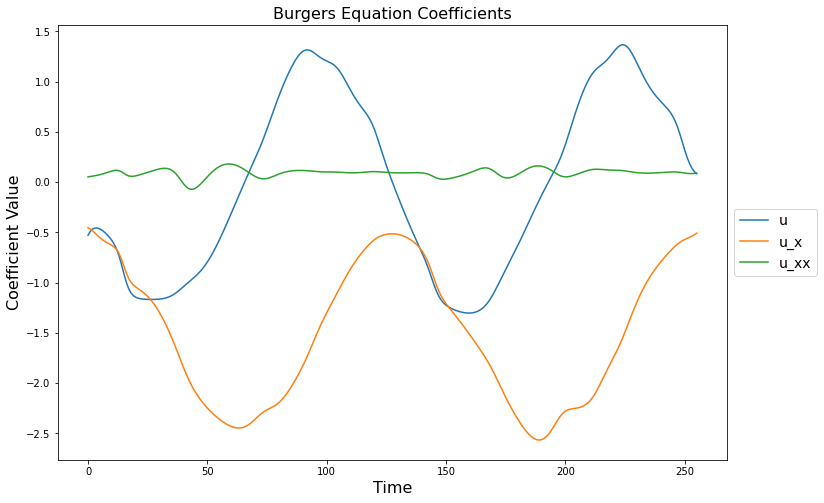

In [21]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-6:
        print(j, '->', poly_feature_names[j])
        plot(xi[j,:], label = poly_feature_names[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

In [22]:
equations = pysr(
    x, xi[0, :],
    populations=50, npop=1500, niterations=5,
    binary_operators=["+", "*"],
    unary_operators=["sin", "cos"],
)

Running on julia -O3 /var/folders/z3/_stfms3523dd5mnfr3ch5n100000gp/T/tmpeplammas/runfile.jl
Activating environment on workers.
      From worker 3:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 4:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 5:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 2:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 9.330e+02
Head worker occupation: 2.3%
Progress: 1 / 250 total iterations (0.400%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           7.953e-01  -0.000e+00  -0.021080764
3           6.694e-01  8.618e-02  (0.12313102 * x0)
4           4.1

In [23]:
best(equations)

-sin(1.2618194*x0)

In [24]:
equations = pysr(
    x, xi[1, :],
    populations=50, npop=1500, niterations=5,
    binary_operators=["+", "*"],
    unary_operators=["cos"],
)

Running on julia -O3 /var/folders/z3/_stfms3523dd5mnfr3ch5n100000gp/T/tmp_zf2euec/runfile.jl
Activating environment on workers.
      From worker 4:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 3:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 5:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 2:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 7.270e+02
Head worker occupation: 1.9%
Progress: 1 / 250 total iterations (0.400%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           4.719e-01  -0.000e+00  -1.5008688
4           2.747e-01  1.803e-01  (-1.3091099 + cos(x0))
6           

In [25]:
best(equations)

cos(1.2590762*x0) - 1.5028094

In [26]:
# Note: 2*np.pi/5 = 1.2566370614359172

### Noisless results ###
# Feature importance, noisless, 20000 samples
# [u, (t, x), u_x, u_xx, u_xxx, u_xxxx] use this one, (1.2523253 * sin(-1.2530949*x)) | cos(1.2594514*x)−1.5031303
# [0.9530, 0.2164, 0.7234, 0.3194, 0.0947, 0.1568]

### Noisy (x, t) and noisy labels results ### (Worst)
# Feature importance, 20000 samples, (1.2010298 * sin(-1.2499514*x)) | cos(1.2681643*x)−1.4841684
# [u, (t, x), u_x, u_xx, u_xxx, u_xxxx]
# [0.8290, 0.1519, 0.5936, 0.2880, 0.1105, 0.1368]

### Clean (x, t) and noisy labels results ###
# Feature importance, 20000 samples, (1.2536734 * sin(-1.252591*x)) | cos(1.2590762*x)−1.5028094
# [u, (t, x), u_x, u_xx, u_xxx, u_xxxx]
# [0.8957, 0.1703, 0.5571, 0.2591, 0.1084, 0.1218]